# RAG System Testing: Baseline vs Full RAG

Сравнение двух систем:
- **Baseline RAG**: простое разбиение (1000 tokens) + векторный поиск (embeddings)
- **Full RAG**: VLM анализ + таблицы + hybrid search + reranking + query expansion

Оценка по **document_url** (правильная страница найдена)

## 0. Imports & Setup

In [1]:
import logging
import re
import uuid
import warnings
from pathlib import Path
from typing import Dict, List

import chromadb
import httpx
import matplotlib.pyplot as plt
import numpy as np
import ollama
import pandas as pd
import pypandoc
import seaborn as sns
from chromadb.config import Settings
from langchain_text_splitters import MarkdownTextSplitter
from PIL import Image
from tqdm.notebook import tqdm

from src.config import load_config
from src.rag import RAGSystem
from src.utils.logging_config import setup_logging

warnings.filterwarnings("ignore")
# Visual
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

logger = logging.getLogger("RAG_TEST")
logger.setLevel(logging.INFO)

print("✓ Imports loaded")

✓ Imports loaded


## 1. BaselineRAGSystem Class

In [2]:
class BaselineRAGSystem:
    """Простая RAG система: RST → Markdown → chunks → embeddings → vector search."""
    
    def __init__(self, 
                 ollama_client: ollama.Client,
                 embedding_model: str = "nomic-embed-text:v1.5",
                 chunk_size: int = 1000,
                 chunk_overlap: int = 100,
                 db_path: str = "./baseline_chroma_db"):
        self.ollama_client = ollama_client
        self.embedding_model = embedding_model
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap
        
        # ChromaDB for vector storage
        self.chroma_client = chromadb.PersistentClient(
            path=db_path,
            settings=Settings(anonymized_telemetry=False)
        )
        self.collection = self.chroma_client.get_or_create_collection(
            name="baseline_collection",
            metadata={"hnsw:space": "cosine"}
        )
        
        print(f"✓ BaselineRAGSystem initialized")
        print(f"  Chunk size: {chunk_size}")
        print(f"  Embedding model: {embedding_model}")
    
    def _convert_rst_to_markdown(self, rst_content: str) -> str:
        """Convert RST to Markdown."""
        try:
            return pypandoc.convert_text(
                rst_content, "gfm", format="rst", extra_args=["--wrap=none"]
            )
        except:
            return rst_content
    
    def _chunk_text(self, text: str) -> List[str]:
        """Split text into chunks."""
        splitter = MarkdownTextSplitter(
            chunk_size=self.chunk_size,
            chunk_overlap=self.chunk_overlap,
        )
        return splitter.split_text(text)
    
    def _generate_embedding(self, text: str) -> List[float]:
        """Generate embedding via Ollama."""
        try:
            # Truncate if too long
            max_length = 8000
            truncated = text[:max_length] if len(text) > max_length else text
            
            response = self.ollama_client.embeddings(
                model=self.embedding_model,
                prompt=truncated,
                keep_alive=10
            )
            return response['embedding']
        except Exception as e:
            logger.error(f"Embedding error: {e}")
            return [0.0] * 768  # Default dimension
    
    def add_document(self, 
                    rst_content: str, 
                    document_url: str,
                    file_id: str) -> int:
        """Add document to baseline system."""
        # Convert RST → Markdown
        markdown = self._convert_rst_to_markdown(rst_content)
        
        # Chunk
        chunks = self._chunk_text(markdown)
        
        # Generate embeddings and add to ChromaDB
        chunk_ids = []
        embeddings = []
        documents = []
        metadatas = []
        
        for idx, chunk_text in enumerate(chunks):
            chunk_id = f"{file_id}_baseline_{idx}"
            embedding = self._generate_embedding(chunk_text)
            
            chunk_ids.append(chunk_id)
            embeddings.append(embedding)
            documents.append(chunk_text)
            metadatas.append({
                "file_id": file_id,
                "document_url": document_url,
                "chunk_index": idx
            })
        
        # Add to ChromaDB
        if chunk_ids:
            self.collection.add(
                ids=chunk_ids,
                embeddings=embeddings,
                documents=documents,
                metadatas=metadatas
            )
        
        return len(chunk_ids)
    
    def search(self, query: str, top_k: int = 10) -> List[Dict]:
        """Search in baseline system."""
        # Generate query embedding
        query_embedding = self._generate_embedding(query)
        
        # Search in ChromaDB
        results = self.collection.query(
            query_embeddings=[query_embedding],
            n_results=top_k
        )
        
        # Format results
        formatted_results = []
        for i in range(len(results['ids'][0])):
            formatted_results.append({
                'chunk_id': results['ids'][0][i],
                'content': results['documents'][0][i],
                'document_url': results['metadatas'][0][i].get('document_url', ''),
                'score': 1.0 - results['distances'][0][i]  # Convert distance to similarity
            })
        
        return formatted_results
    
    def get_all_chunks(self) -> List[Dict]:
        """Get all chunks from baseline system."""
        results = self.collection.get()
        
        chunks = []
        for i in range(len(results['ids'])):
            chunks.append({
                'chunk_id': results['ids'][i],
                'content': results['documents'][i],
                'document_url': results['metadatas'][i].get('document_url', ''),
                'file_id': results['metadatas'][i].get('file_id', '')
            })
        
        return chunks
    
    def cleanup(self):
        """Clean up baseline system."""
        self.chroma_client.delete_collection("baseline_collection")
        print("✓ Baseline collection deleted")

print("✓ BaselineRAGSystem class defined")

✓ BaselineRAGSystem class defined


## 2. Initialize Systems

In [3]:
# Load config
config = load_config("testing/test_config.toml")
setup_logging(config.logging)

print("Full RAG Configuration:")
print(f"  Embedding: {config.text_embedding_model}")
print(f"  LLM: {config.text_generation_model}")
print(f"  VLM: {config.vlm_model}")
print(f"  Query expansion: {config.query_expansion_enabled}")
print(f"  Reranker: {config.reranker_enabled}")

# Initialize Ollama client
ollama_client = ollama.Client(
    config.ollama_base_url,
    timeout=httpx.Timeout(connect=10.0, read=300.0, write=10.0, pool=10.0),
)

# Initialize Baseline RAG
print("\n" + "="*60)
baseline_rag = BaselineRAGSystem(
    ollama_client=ollama_client,
    embedding_model="nomic-embed-text:v1.5",
    chunk_size=1000,
    chunk_overlap=100,
    db_path="testing/baseline_chroma_test"
)

# Initialize Full RAG
print("\n" + "="*60)
full_rag = RAGSystem(config)

async def init_full_rag():
    await full_rag.initialize()
    return full_rag.is_ready()

is_ready = await init_full_rag()
print(f"\n✓ Full RAG ready: {is_ready}")
print("="*60)

2025-12-12 14:16:22 src.utils.logging_config  [INFO] ======================================================================
2025-12-12 14:16:22 src.utils.logging_config  [INFO] Logging initialized: level=INFO, colors=True, emoji=False
2025-12-12 14:16:22 src.utils.logging_config  [INFO] ======================================================================
Full RAG Configuration:
  Embedding: nomic-embed-text:v1.5
  LLM: qwen3:4b-instruct-2507-q4_K_M
  VLM: qwen3-vl:4b-instruct
  Query expansion: True
  Reranker: True

✓ BaselineRAGSystem initialized
  Chunk size: 1000
  Embedding model: nomic-embed-text:v1.5

2025-12-12 14:16:22 src.rag.main              [INFO] RAG System v4.0 created
2025-12-12 14:16:22 src.rag.main              [INFO] Initializing RAG System v4.0...
2025-12-12 14:16:22 src.rag.main              [INFO] ✓ Ollama connection verified
2025-12-12 14:16:22 src.rag.main              [INFO] ✓ VLM model qwen3-vl:4b-instruct found
2025-12-12 14:16:22 src.rag.main              

## 3. Collect RST Documents

In [4]:
base_url = "https://doc.ru.universe-data.ru/6.13.0-EE"
docs_base_path = Path("/home/serg_fedchn/Homework/7_semester/MML/project/hse-mml-project/data/sphinx-service-docs-6.13.0-RU/docs")
guides_path = docs_base_path / "content" / "guides"
getting_started_path = docs_base_path / "content" / "getting_started"

# Collect all RST files
rst_files = []
rst_files.extend(list(guides_path.rglob("*.rst")))
rst_files.extend(list(getting_started_path.rglob("*.rst")))

print(f"Total RST files: {len(rst_files)}")

# CONFIGURATION
MAX_FILES = 100  # ← ADJUST THIS
rst_files = sorted(rst_files)[:MAX_FILES]

# Create file → URL mapping
file_to_url = {}
file_to_id = {}

for rst_file in rst_files:
    relative_path = rst_file.relative_to(docs_base_path)
    doc_url = f"{base_url}/{relative_path.with_suffix('.html')}"
    file_id = f"doc_{uuid.uuid4().hex[:8]}"
    
    file_to_url[rst_file] = doc_url
    file_to_id[rst_file] = file_id

print(f"\nUsing {len(rst_files)} files")
print(f"\nExample:")
for f in list(rst_files)[:3]:
    print(f"  {f.name}")
    print(f"    → {file_to_url[f][:70]}...")

Total RST files: 271

Using 100 files

Example:
  createwfstart.rst
    → https://doc.ru.universe-data.ru/6.13.0-EE/content/getting_started/data...
  customfuncstart.rst
    → https://doc.ru.universe-data.ru/6.13.0-EE/content/getting_started/data...
  dqconfigstart.rst
    → https://doc.ru.universe-data.ru/6.13.0-EE/content/getting_started/data...


## 4. Index Documents in Both Systems

In [5]:
print("Indexing documents in BOTH systems...\n")

baseline_stats = []
fullrag_stats = []

for rst_file in tqdm(rst_files, desc="Indexing"):
    try:
        file_id = file_to_id[rst_file]
        doc_url = file_to_url[rst_file]
        rst_content = rst_file.read_text(encoding='utf-8', errors='ignore')
        
        # ===== BASELINE RAG =====
        num_chunks_baseline = baseline_rag.add_document(
            rst_content=rst_content,
            document_url=doc_url,
            file_id=file_id
        )
        baseline_stats.append({
            'file_id': file_id,
            'document_url': doc_url,
            'chunks': num_chunks_baseline
        })
        
        # ===== FULL RAG =====
        doc_id = await full_rag.add_document(
            rst_content=rst_content,
            document_url=doc_url,
            images_base_path=str(docs_base_path),
            file_id=file_id
        )
        fullrag_stats.append({
            'file_id': file_id,
            'document_url': doc_url,
            'doc_id': doc_id
        })
        
    except Exception as e:
        logger.warning(f"Failed {rst_file.name}: {e}")

print(f"\n✓ Indexing complete")
print(f"\nBaseline RAG:")
print(f"  Documents: {len(baseline_stats)}")
print(f"  Total chunks: {sum(s['chunks'] for s in baseline_stats)}")
print(f"  Avg chunks/doc: {sum(s['chunks'] for s in baseline_stats) / len(baseline_stats):.1f}")

print(f"\nFull RAG:")
print(f"  Documents: {len(fullrag_stats)}")
print(f"  (with VLM analysis, tables, etc.)")

Indexing documents in BOTH systems...



Indexing:   0%|          | 0/100 [00:00<?, ?it/s]

2025-12-12 14:16:24 src.rag.main              [INFO] Adding document: https://doc.ru.universe-data.ru/6.13.0-EE/content/getting_started/datamodel/createwfstart.html
2025-12-12 14:16:24 src.rag.ingestion         [INFO] Processing document doc_5fa047cd: https://doc.ru.universe-data.ru/6.13.0-EE/content/getting_started/datamodel/createwfstart.html
2025-12-12 14:16:24 src.rag.ingestion         [INFO] Extracted 0 tables
2025-12-12 14:16:24 src.rag.ingestion         [INFO] Created 4 text chunks
2025-12-12 14:16:24 src.rag.ingestion         [INFO] Created 0 table chunks
2025-12-12 14:16:24 src.rag.ingestion         [INFO] Created 0 image-content chunks
2025-12-12 14:16:24 src.rag.storage           [INFO] Added 4 chunks to VectorStorage
2025-12-12 14:16:24 src.rag.search            [INFO] Building BM25 index from 4 documents...
2025-12-12 14:16:24 src.rag.search            [INFO] ✓ BM25 index built (4 documents)
2025-12-12 14:16:24 src.rag.search            [INFO] ✓ BM25 index saved to cache: 

[WARNING] Reference not found for '613_default' at chunk line 1 column 13


2025-12-12 14:21:37 pypandoc                  [WARNING] Reference not found for '613_default' at chunk line 1 column 13


[WARNING] Reference not found for '613_default' at chunk line 1 column 13



2025-12-12 14:21:37 pypandoc                  [WARNING] Reference not found for '613_default' at chunk line 1 column 13

2025-12-12 14:21:38 src.rag.main              [INFO] Adding document: https://doc.ru.universe-data.ru/6.13.0-EE/content/guides/configure/opensearchindex.html
2025-12-12 14:21:38 src.rag.ingestion         [INFO] Processing document doc_612dabaa: https://doc.ru.universe-data.ru/6.13.0-EE/content/guides/configure/opensearchindex.html
2025-12-12 14:21:38 src.rag.ingestion         [INFO] Extracted 1 tables
2025-12-12 14:21:38 src.rag.ingestion         [INFO] Created 4 text chunks
2025-12-12 14:21:38 src.rag.ingestion         [INFO] Created 1 table chunks
2025-12-12 14:21:38 src.rag.ingestion         [INFO] Created 0 image-content chunks
2025-12-12 14:21:38 src.rag.storage           [INFO] Added 5 chunks to VectorStorage
2025-12-12 14:21:38 src.rag.search            [INFO] ✓ BM25 cache invalidated
2025-12-12 14:21:38 src.rag.search            [INFO] Building BM25 index fro

[WARNING] Reference not found for 'Key "\" \1091\1082\1072\1079\1099\1074\1072\1077\1090\1089\1103 \1080\1084\1103 \1082\1083\1072\1089\1089\1080\1092\1080\1082\1072\1090\1086\1088\1072 (industrial_machine), \1077\1075\1086 \1074\1077\1088\1089\1080\1103 (machine) \1080 \1085\1077\1086\1073\1093\1086\1076\1080\1084\1099\1081 \1091\1079\1077\1083 (milling), \1079\1072\1090\1077\1084 \1074 \1082\1086\1085\1094\1077 - \1072\1090\1088\1080\1073\1091\1090 (type). \1087\1088\1080\1084\1077\1088: \"classification:industrial_machine"' at chunk line 1 column 285



2025-12-12 14:28:38 pypandoc                  [WARNING] Reference not found for 'Key "\" \1091\1082\1072\1079\1099\1074\1072\1077\1090\1089\1103 \1080\1084\1103 \1082\1083\1072\1089\1089\1080\1092\1080\1082\1072\1090\1086\1088\1072 (industrial_machine), \1077\1075\1086 \1074\1077\1088\1089\1080\1103 (machine) \1080 \1085\1077\1086\1073\1093\1086\1076\1080\1084\1099\1081 \1091\1079\1077\1083 (milling), \1079\1072\1090\1077\1084 \1074 \1082\1086\1085\1094\1077 - \1072\1090\1088\1080\1073\1091\1090 (type). \1087\1088\1080\1084\1077\1088: \"classification:industrial_machine"' at chunk line 1 column 285

2025-12-12 14:28:38 src.rag.main              [INFO] Adding document: https://doc.ru.universe-data.ru/6.13.0-EE/content/guides/data_admin/dqtools/ruleadvance/dqsets.html
2025-12-12 14:28:38 src.rag.ingestion         [INFO] Processing document doc_efa43fc8: https://doc.ru.universe-data.ru/6.13.0-EE/content/guides/data_admin/dqtools/ruleadvance/dqsets.html
2025-12-12 14:28:38 src.rag.ingestio

[WARNING] Reference not found for 'Key "\" \1091\1082\1072\1079\1099\1074\1072\1077\1090\1089\1103 \1080\1084\1103 \1082\1083\1072\1089\1089\1080\1092\1080\1082\1072\1090\1086\1088\1072 (industrial_machine), \1077\1075\1086 \1074\1077\1088\1089\1080\1103 (machine) \1080 \1085\1077\1086\1073\1093\1086\1076\1080\1084\1099\1081 \1091\1079\1077\1083 (milling), \1079\1072\1090\1077\1084 \1074 \1082\1086\1085\1094\1077 - \1072\1090\1088\1080\1073\1091\1090 (type). \1087\1088\1080\1084\1077\1088: \"classification:industrial_machine"' at chunk line 1 column 285



2025-12-12 14:28:39 pypandoc                  [WARNING] Reference not found for 'Key "\" \1091\1082\1072\1079\1099\1074\1072\1077\1090\1089\1103 \1080\1084\1103 \1082\1083\1072\1089\1089\1080\1092\1080\1082\1072\1090\1086\1088\1072 (industrial_machine), \1077\1075\1086 \1074\1077\1088\1089\1080\1103 (machine) \1080 \1085\1077\1086\1073\1093\1086\1076\1080\1084\1099\1081 \1091\1079\1077\1083 (milling), \1079\1072\1090\1077\1084 \1074 \1082\1086\1085\1094\1077 - \1072\1090\1088\1080\1073\1091\1090 (type). \1087\1088\1080\1084\1077\1088: \"classification:industrial_machine"' at chunk line 1 column 285

2025-12-12 14:28:39 src.rag.ingestion         [INFO] Created 14 text chunks
2025-12-12 14:28:39 src.rag.ingestion         [INFO] Created 0 table chunks
2025-12-12 14:28:49 src.rag.ingestion         [INFO] Created 4 image-content chunks
2025-12-12 14:29:00 src.rag.storage           [INFO] Added 18 chunks to VectorStorage
2025-12-12 14:29:00 src.rag.search            [INFO] ✓ BM25 cache inval

## 5. Extract Chunks for Query Generation

In [6]:
print("Extracting chunks for query generation...")

# Get all baseline chunks
baseline_chunks = baseline_rag.get_all_chunks()
print(f"\nBaseline chunks: {len(baseline_chunks)}")

# Get Full RAG chunks
fullrag_chunks = full_rag.vector_storage.get_all_documents()
print(f"Full RAG chunks: {len(fullrag_chunks)}")

# Separate by type
fullrag_image_chunks = [
    doc for doc in fullrag_chunks 
    if doc['metadata'].get('type') == 'image_content'
]

print(f"  - Image chunks (VLM): {len(fullrag_image_chunks)}")

Extracting chunks for query generation...

Baseline chunks: 603
Full RAG chunks: 918
  - Image chunks (VLM): 344


## 6. Generate TEXT Queries

In [7]:
class QueryGenerator:
    def __init__(self, ollama_client, llm_model: str):
        self.ollama_client = ollama_client
        self.llm_model = llm_model
    
    def generate_queries(self, content: str, num_queries: int = 2) -> List[str]:
        if len(content) > 1500:
            content = content[:1500] + "..."
        
        prompt = f"""Based on this technical documentation, generate {num_queries} short questions (1-2 sentences) in Russian.

Documentation:
```
{content}
```

ONLY questions, one per line:"""
        
        try:
            response = self.ollama_client.chat(
                model=self.llm_model,
                messages=[{"role": "user", "content": prompt}],
                options={"temperature": 0.7, "num_predict": 200},
                keep_alive=10,
                stream=False,
            )
            text = response.message.content.strip()
            queries = [q.strip() for q in text.split('\n') if q.strip()]
            queries = [re.sub(r'^\d+\.\s*', '', q) for q in queries]
            return queries[:num_queries]
        except Exception as e:
            logger.warning(f"Query gen failed: {e}")
            return []

query_gen = QueryGenerator(ollama_client, config.text_generation_model)

print("Generating TEXT queries from baseline chunks...")
test_queries = []  # [{query, document_url, type}]

# Sample chunks per document
docs_sampled = {}
for chunk in baseline_chunks:
    doc_url = chunk['document_url']
    if doc_url not in docs_sampled:
        docs_sampled[doc_url] = []
    docs_sampled[doc_url].append(chunk)

# Generate queries from ~5 chunks per document
for doc_url, chunks in tqdm(docs_sampled.items(), desc="Text queries"):
    sample_size = min(5, len(chunks))
    sample_indices = np.linspace(0, len(chunks)-1, sample_size, dtype=int)
    
    for idx in sample_indices:
        chunk = chunks[idx]
        queries = query_gen.generate_queries(chunk['content'], num_queries=2)
        
        for query in queries:
            if query and len(query) > 10:
                test_queries.append({
                    'query': query,
                    'document_url': doc_url,
                    'type': 'text'
                })

print(f"\n✓ Text queries generated: {len(test_queries)}")

Generating TEXT queries from baseline chunks...


Text queries:   0%|          | 0/100 [00:00<?, ?it/s]


✓ Text queries generated: 758


## 7. Generate IMAGE Queries (VLM)

In [8]:
class ImageQueryGenerator:
    def __init__(self, ollama_client, vlm_model: str):
        self.ollama_client = ollama_client
        self.vlm_model = vlm_model
    
    def generate_queries_from_image(self, image_path: Path, num_queries: int = 2) -> List[str]:
        try:
            img = Image.open(image_path)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            
            prompt = f"""Analyze this screenshot from technical documentation. Generate {num_queries} short questions (1-2 sentences) in Russian, that would require this image to answer it.

Examples:
- "Как настроить параметр X?"
- "Где находится кнопка экспорта?"

Do NOT generate questions, that reference this image directly, like "Что на этом изображении?". The questions should be about the interface, NOT the image itself.

ONLY questions, one per line:"""
            
            response = self.ollama_client.chat(
                model=self.vlm_model,
                messages=[{
                    "role": "user",
                    "content": prompt,
                    "images": [str(image_path)]
                }],
                options={"temperature": 0.7, "num_predict": 200},
                keep_alive=10,
                stream=False,
            )
            
            text = response.message.content.strip()
            queries = [q.strip() for q in text.split('\n') if q.strip()]
            queries = [re.sub(r'^\d+\.\s*', '', q) for q in queries]
            queries = [q for q in queries if len(q) > 10]
            return queries[:num_queries]
        except Exception as e:
            logger.warning(f"Image query gen failed: {e}")
            return []

if config.vlm_model:
    image_query_gen = ImageQueryGenerator(ollama_client, config.vlm_model)
    
    print("Generating IMAGE queries with VLM...")
    print("⚠️  This may take time\n")
    
    MAX_IMAGES = min(100, len(fullrag_image_chunks))
    
    for chunk_doc in tqdm(fullrag_image_chunks[:MAX_IMAGES], desc="Image queries"):
        img_path = chunk_doc['metadata'].get('image_path')
        doc_url = chunk_doc['metadata'].get('document_url', '')
        
        if not img_path or not Path(img_path).exists():
            continue
        
        queries = image_query_gen.generate_queries_from_image(Path(img_path), num_queries=2)
        
        for query in queries:
            if query:
                test_queries.append({
                    'query': query,
                    'document_url': doc_url,
                    'type': 'image'
                })
    
    print(f"\n✓ Image queries generated")
else:
    print("⚠️  VLM not configured, skipping image queries")

print(f"\n✓ Total queries: {len(test_queries)}")
print(f"  - Text: {sum(1 for q in test_queries if q['type'] == 'text')}")
print(f"  - Image: {sum(1 for q in test_queries if q['type'] == 'image')}")

Generating IMAGE queries with VLM...
⚠️  This may take time



Image queries:   0%|          | 0/100 [00:00<?, ?it/s]

2025-12-12 14:42:22 RAG_TEST                  [WARNING] Image query gen failed: model runner has unexpectedly stopped, this may be due to resource limitations or an internal error, check ollama server logs for details (status code: 500)
2025-12-12 14:42:31 RAG_TEST                  [WARNING] Image query gen failed: model runner has unexpectedly stopped, this may be due to resource limitations or an internal error, check ollama server logs for details (status code: 500)
2025-12-12 14:42:33 RAG_TEST                  [WARNING] Image query gen failed: model runner has unexpectedly stopped, this may be due to resource limitations or an internal error, check ollama server logs for details (status code: 500)
2025-12-12 14:42:35 RAG_TEST                  [WARNING] Image query gen failed: model runner has unexpectedly stopped, this may be due to resource limitations or an internal error, check ollama server logs for details (status code: 500)
2025-12-12 14:42:36 RAG_TEST                  [WARNI

## 8. Metrics

In [9]:
class RankingMetrics:
    @staticmethod
    def recall_at_k(retrieved_urls: List[str], target_url: str, k: int) -> float:
        """Did we find the correct page in top-K?"""
        if not target_url:
            return 0.0
        return 1.0 if target_url in retrieved_urls[:k] else 0.0
    
    @staticmethod
    def precision_at_k(retrieved_urls: List[str], target_url: str, k: int) -> float:
        """What fraction of top-K is from correct page?"""
        if k == 0 or not target_url:
            return 0.0
        count = sum(1 for url in retrieved_urls[:k] if url == target_url)
        return count / k
    
    @staticmethod
    def mrr(retrieved_urls: List[str], target_url: str) -> float:
        """Mean Reciprocal Rank."""
        if not target_url:
            return 0.0
        for i, url in enumerate(retrieved_urls, 1):
            if url == target_url:
                return 1.0 / i
        return 0.0
    
    @staticmethod
    def ndcg_at_k(retrieved_urls: List[str], target_url: str, k: int) -> float:
        """NDCG."""
        if not target_url:
            return 0.0
        dcg = sum(
            1.0 / np.log2(i + 1) 
            for i, url in enumerate(retrieved_urls[:k], 1) 
            if url == target_url
        )
        idcg = 1.0
        return dcg / idcg if idcg > 0 else 0.0

metrics = RankingMetrics()
print("✓ Metrics ready")

✓ Metrics ready


## 9. Run Evaluation

In [10]:
results = {"baseline": [], "full_rag": []}

print("Running evaluation...\n")
print(f"Testing {len(test_queries)} queries\n")

for query_data in tqdm(test_queries, desc="Evaluating"):
    query = query_data['query']
    target_url = query_data['document_url']
    query_type = query_data['type']
    
    # ===== BASELINE RAG =====
    try:
        baseline_results = baseline_rag.search(query, top_k=10)
        baseline_urls = [r['document_url'] for r in baseline_results]
    except Exception as e:
        logger.warning(f"Baseline error: {e}")
        baseline_urls = []
    
    results["baseline"].append({
        "query": query,
        "target_url": target_url,
        "query_type": query_type,
        "method": "baseline",
        "recall@5": metrics.recall_at_k(baseline_urls, target_url, 5),
        "recall@10": metrics.recall_at_k(baseline_urls, target_url, 10),
        "precision@5": metrics.precision_at_k(baseline_urls, target_url, 5),
        "precision@10": metrics.precision_at_k(baseline_urls, target_url, 10),
        "mrr": metrics.mrr(baseline_urls, target_url),
        "ndcg@5": metrics.ndcg_at_k(baseline_urls, target_url, 5),
        "ndcg@10": metrics.ndcg_at_k(baseline_urls, target_url, 10),
    })
    
    # ===== FULL RAG =====
    try:
        fullrag_results = await full_rag.search(query, top_k=10)
        fullrag_urls = [r.metadata.get('document_url', '') for r in fullrag_results]
    except Exception as e:
        logger.warning(f"Full RAG error: {e}")
        fullrag_urls = []
    
    results["full_rag"].append({
        "query": query,
        "target_url": target_url,
        "query_type": query_type,
        "method": "full_rag",
        "recall@5": metrics.recall_at_k(fullrag_urls, target_url, 5),
        "recall@10": metrics.recall_at_k(fullrag_urls, target_url, 10),
        "precision@5": metrics.precision_at_k(fullrag_urls, target_url, 5),
        "precision@10": metrics.precision_at_k(fullrag_urls, target_url, 10),
        "mrr": metrics.mrr(fullrag_urls, target_url),
        "ndcg@5": metrics.ndcg_at_k(fullrag_urls, target_url, 5),
        "ndcg@10": metrics.ndcg_at_k(fullrag_urls, target_url, 10),
    })

print(f"\n✓ Evaluation complete")

Running evaluation...

Testing 886 queries



Evaluating:   0%|          | 0/886 [00:00<?, ?it/s]

2025-12-12 14:43:45 src.rag.main              [INFO] Search query: 'Как создать учетную запись с доступом к разделу "Бизнес-процессы"?'
2025-12-12 14:43:48 src.rag.query_processing  [INFO] Query expanded: 'Как создать учетную запись с доступом к разделу "Бизнес-процессы"?' -> ['создание учетной записи', 'доступ к разделу', 'бизнес-процессы']
2025-12-12 14:43:48 src.rag.main              [INFO] Search queries: ['создание учетной записи', 'доступ к разделу', 'бизнес-процессы']
2025-12-12 14:43:49 src.rag.search            [INFO] Hybrid search returned 99 unique candidates
2025-12-12 14:43:49 src.rag.main              [INFO] Retrieved 50 candidates
2025-12-12 14:43:49 src.rag.ranking           [INFO] Loading CrossEncoder model: BAAI/bge-reranker-v2-m3...
2025-12-12 14:43:52 src.rag.ranking           [INFO] ✓ CrossEncoder model loaded: BAAI/bge-reranker-v2-m3
2025-12-12 14:43:53 src.rag.ranking           [INFO] Reranked 50 candidates, returning top-10
2025-12-12 14:43:53 src.rag.ranking   

## 10. Analysis

In [11]:
df_baseline = pd.DataFrame(results["baseline"])
df_full_rag = pd.DataFrame(results["full_rag"])

metrics_cols = ["recall@5", "recall@10", "precision@5", "precision@10", "mrr", "ndcg@5", "ndcg@10"]

summary_baseline = df_baseline[metrics_cols].mean()
summary_full_rag = df_full_rag[metrics_cols].mean()

comparison = pd.DataFrame({
    "Baseline RAG": summary_baseline,
    "Full RAG": summary_full_rag,
    "Improvement (%)": ((summary_full_rag - summary_baseline) / (summary_baseline + 1e-6) * 100).round(2)
}).round(4)

print("\n" + "="*80)
print("OVERALL RESULTS")
print("="*80)
print(f"\nDataset:")
print(f"  Documents: {len(baseline_stats)}")
print(f"  Queries: {len(df_baseline)}")
print(f"    - Text: {(df_baseline['query_type'] == 'text').sum()}")
print(f"    - Image: {(df_baseline['query_type'] == 'image').sum()}")

print(f"\nBaseline RAG:")
print(f"  Chunk size: 1000")
print(f"  Search: vector only (embeddings)")
print(f"  Total chunks: {len(baseline_chunks)}")

print(f"\nFull RAG:")
print(f"  VLM analysis: enabled")
print(f"  Query expansion: {config.query_expansion_enabled}")
print(f"  Reranker: {config.reranker_enabled}")
print(f"  Hybrid search: vector + BM25")

print(f"\nMetrics:")
print(comparison.to_string())
print("\n" + "="*80)


OVERALL RESULTS

Dataset:
  Documents: 100
  Queries: 886
    - Text: 758
    - Image: 128

Baseline RAG:
  Chunk size: 1000
  Search: vector only (embeddings)
  Total chunks: 603

Full RAG:
  VLM analysis: enabled
  Query expansion: True
  Reranker: True
  Hybrid search: vector + BM25

Metrics:
              Baseline RAG  Full RAG  Improvement (%)
recall@5            0.4763    0.8747            83.65
recall@10           0.5621    0.8939            59.04
precision@5         0.1330    0.4165           213.24
precision@10        0.0911    0.2808           208.30
mrr                 0.3789    0.7875           107.83
ndcg@5              0.4911    1.4190           188.95
ndcg@10             0.5707    1.6542           189.87



## 11. Analysis by Query Type

In [12]:
# Text queries
bl_text = df_baseline[df_baseline['query_type'] == 'text'][metrics_cols].mean()
rag_text = df_full_rag[df_full_rag['query_type'] == 'text'][metrics_cols].mean()
comp_text = pd.DataFrame({
    "Baseline": bl_text,
    "Full RAG": rag_text,
    "Improv (%)": ((rag_text - bl_text) / (bl_text + 1e-6) * 100).round(2)
}).round(4)

print("\n" + "="*80)
print("TEXT QUERIES")
print("="*80)
print(comp_text.to_string())

# Image queries (if any)
if (df_baseline['query_type'] == 'image').sum() > 0:
    bl_img = df_baseline[df_baseline['query_type'] == 'image'][metrics_cols].mean()
    rag_img = df_full_rag[df_full_rag['query_type'] == 'image'][metrics_cols].mean()
    comp_img = pd.DataFrame({
        "Baseline": bl_img,
        "Full RAG": rag_img,
        "Improv (%)": ((rag_img - bl_img) / (bl_img + 1e-6) * 100).round(2)
    }).round(4)
    
    print("\n" + "="*80)
    print("IMAGE QUERIES (VLM Generated)")
    print("="*80)
    print(comp_img.to_string())

print("\n" + "="*80)


TEXT QUERIES
              Baseline  Full RAG  Improv (%)
recall@5        0.5290    0.9129       72.57
recall@10       0.6227    0.9248       48.52
precision@5     0.1470    0.4364      196.95
precision@10    0.1011    0.2934      190.34
mrr             0.4222    0.8281       96.15
ndcg@5          0.5450    1.4920      173.76
ndcg@10         0.6342    1.7355      173.64

IMAGE QUERIES (VLM Generated)
              Baseline  Full RAG  Improv (%)
recall@5        0.1641    0.6484      295.24
recall@10       0.2031    0.7109      250.00
precision@5     0.0500    0.2984      496.87
precision@10    0.0320    0.2062      543.89
mrr             0.1227    0.5470      345.86
ndcg@5          0.1717    0.9867      474.57
ndcg@10         0.1943    1.1727      503.57



## 12. Visualization

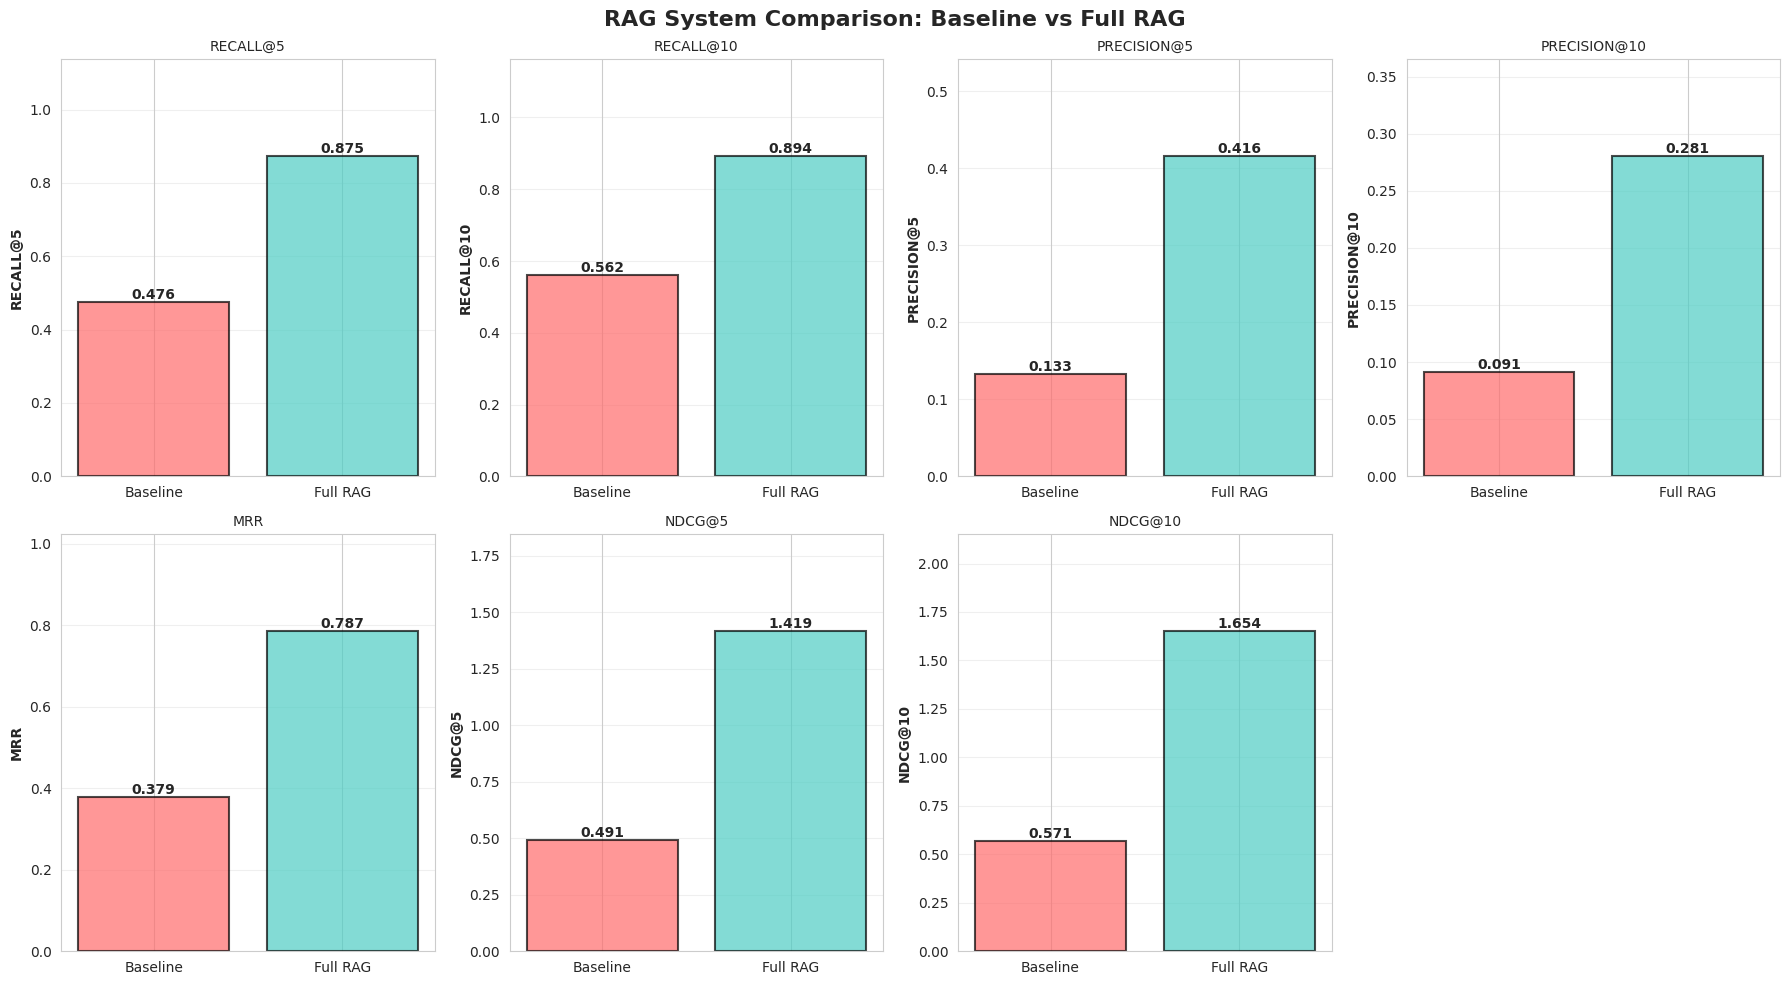

✓ Saved: testing/rag_comparison_results.png


In [13]:
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
fig.suptitle("RAG System Comparison: Baseline vs Full RAG", 
             fontsize=16, fontweight='bold')

metrics_plot = ["recall@5", "recall@10", "precision@5", "precision@10", "mrr", "ndcg@5", "ndcg@10"]
colors = ["#FF6B6B", "#4ECDC4"]

for idx, metric in enumerate(metrics_plot):
    if idx >= 7:
        break
    ax = axes[idx // 4, idx % 4]
    
    data = [summary_baseline[metric], summary_full_rag[metric]]
    bars = ax.bar(["Baseline", "Full RAG"], data, color=colors, alpha=0.7, 
                  edgecolor='black', linewidth=1.5)
    
    for bar, val in zip(bars, data):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax.set_ylabel(metric.upper(), fontweight='bold')
    ax.set_title(f"{metric.upper()}", fontsize=10)
    ax.set_ylim(0, max(data) * 1.3 if max(data) > 0 else 1.0)
    ax.grid(axis='y', alpha=0.3)

# Hide last subplot if needed
if len(metrics_plot) < 8:
    axes[1, 3].axis('off')

plt.tight_layout()
plt.savefig('testing/rag_comparison_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: testing/rag_comparison_results.png")

## 14. Cleanup

In [15]:
print("Cleaning up...")

# Cleanup Baseline
try:
    baseline_rag.cleanup()
except Exception as e:
    logger.warning(f"Baseline cleanup: {e}")

# Cleanup Full RAG
for file_id in tqdm([s['file_id'] for s in fullrag_stats], desc="Deleting"):
    try:
        await full_rag.delete_document(file_id)
    except:
        pass

await full_rag.cleanup()
print("\n✓ Cleanup complete")

Cleaning up...
✓ Baseline collection deleted


Deleting:   0%|          | 0/100 [00:00<?, ?it/s]

2025-12-12 16:13:10 src.rag.main              [INFO] Starting COMPLETE deletion of document doc_5fa047cd
2025-12-12 16:13:10 src.rag.main              [INFO] Found 4 chunks to delete
2025-12-12 16:13:10 src.rag.main              [INFO] Deleted 0 physical image files
2025-12-12 16:13:10 src.rag.storage           [INFO] Deleted chunks for file_id=doc_5fa047cd from ChromaDB
2025-12-12 16:13:10 src.rag.search            [INFO] ✓ BM25 cache invalidated
2025-12-12 16:13:10 src.rag.search            [INFO] Building BM25 index from 914 documents...
2025-12-12 16:13:10 src.rag.search            [INFO] ✓ BM25 index built (914 documents)
2025-12-12 16:13:10 src.rag.search            [INFO] ✓ BM25 index saved to cache: testing/rag_engine/chromadb/bm25_cache/bm25_index.pkl
2025-12-12 16:13:10 src.rag.main              [INFO] BM25 index reinitialized without doc_5fa047cd
2025-12-12 16:13:10 src.rag.main              [INFO] ============================================================
2025-12-12 16:13

## 15. Export Results

In [16]:
# Save detailed results
df_all = pd.concat([df_baseline, df_full_rag], ignore_index=True)
df_all.to_csv('testing/rag_comparison_results.csv', index=False)
print("✓ Saved: testing/rag_comparison_results.csv")

# Save summaries
comparison.to_csv('testing/rag_comparison_summary.csv')
comp_text.to_csv('testing/rag_comparison_text.csv')
if (df_baseline['query_type'] == 'image').sum() > 0:
    comp_img.to_csv('testing/rag_comparison_image.csv')
print("✓ Saved: summary CSVs")

# Generate report
report = f"""{'='*80}
RAG SYSTEM COMPARISON REPORT
{'='*80}

Date: {pd.Timestamp.now()}

SYSTEMS COMPARED:

1. Baseline RAG:
   - Simple chunking (1000 tokens)
   - Embeddings: nomic-embed-text:v1.5
   - Search: vector only
   - No VLM, no reranking, no query expansion

2. Full RAG:
   - Smart chunking with VLM analysis
   - Table parsing
   - Hybrid search (vector + BM25)
   - Query expansion: {config.query_expansion_enabled}
   - Reranker: {config.reranker_enabled}

DATASET:
  Documents: {len(baseline_stats)}
  Queries: {len(df_baseline)}
    - Text: {(df_baseline['query_type'] == 'text').sum()}
    - Image: {(df_baseline['query_type'] == 'image').sum()}

OVERALL RESULTS:
{comparison.to_string()}

TEXT QUERIES:
{comp_text.to_string()}

{'IMAGE QUERIES:' if (df_baseline['query_type'] == 'image').sum() > 0 else ''}
{comp_img.to_string() if (df_baseline['query_type'] == 'image').sum() > 0 else 'No image queries'}

KEY FINDINGS:
  - Best Full RAG metric: {comparison['Full RAG'].idxmax()} = {comparison.loc[comparison['Full RAG'].idxmax(), 'Full RAG']:.4f}
  - Largest improvement: {comparison['Improvement (%)'].idxmax()} = +{comparison['Improvement (%)'].max():.2f}%
  - Average improvement: {comparison['Improvement (%)'].mean():.2f}%

INTERPRETATION:
  Recall@5 > 0.7  = Good (correct page in top-5 most of the time)
  MRR > 0.5       = Good (correct page typically in top-2)
  
CONCLUSION:
  Full RAG system shows {'significant' if comparison['Improvement (%)'].mean() > 20 else 'moderate'} improvement
  over simple baseline, justifying the additional complexity.

{'='*80}
"""

print(report)
with open('testing/rag_comparison_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print("\n✓ Saved: testing/rag_comparison_report.txt")
print("\n" + "="*80)
print("ALL DONE! 🎉")
print("="*80)

✓ Saved: testing/rag_comparison_results.csv
✓ Saved: summary CSVs


RAG SYSTEM COMPARISON REPORT

Date: 2025-12-12 16:13:21.788623

SYSTEMS COMPARED:

1. Baseline RAG:
   - Simple chunking (1000 tokens)
   - Embeddings: nomic-embed-text:v1.5
   - Search: vector only
   - No VLM, no reranking, no query expansion

2. Full RAG:
   - Smart chunking with VLM analysis
   - Table parsing
   - Hybrid search (vector + BM25)
   - Query expansion: True
   - Reranker: True

DATASET:
  Documents: 100
  Queries: 886
    - Text: 758
    - Image: 128

OVERALL RESULTS:
              Baseline RAG  Full RAG  Improvement (%)
recall@5            0.4763    0.8747            83.65
recall@10           0.5621    0.8939            59.04
precision@5         0.1330    0.4165           213.24
precision@10        0.0911    0.2808           208.30
mrr                 0.3789    0.7875           107.83
ndcg@5              0.4911    1.4190           188.95
ndcg@10             0.5707    1.6542           189.87

TEXT QUERIES:
              Baseline  Full RAG  Improv (%)
recall@5        0